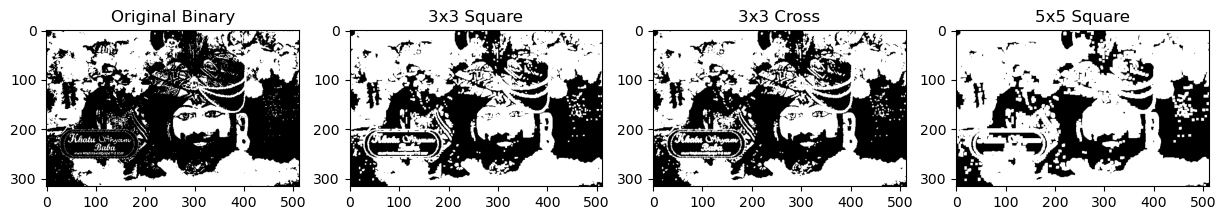

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('input_image.jpg', 0) # Load as grayscale
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

se_3x3_sq = np.ones((3,3), np.uint8)
se_3x3_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
se_5x5_sq = np.ones((5,5), np.uint8)

dil_sq3 = cv2.dilate(binary, se_3x3_sq)
dil_cross3 = cv2.dilate(binary, se_3x3_cross)
dil_sq5 = cv2.dilate(binary, se_5x5_sq)

titles = ['Original Binary', '3x3 Square', '3x3 Cross', '5x5 Square']
images = [binary, dil_sq3, dil_cross3, dil_sq5]

plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(1, 4, i+1), plt.imshow(images[i], 'gray'), plt.title(titles[i])
plt.show()
#Larger structuring elements cause objects to grow more aggressively, while the SE shape influence the geometry of expansion.

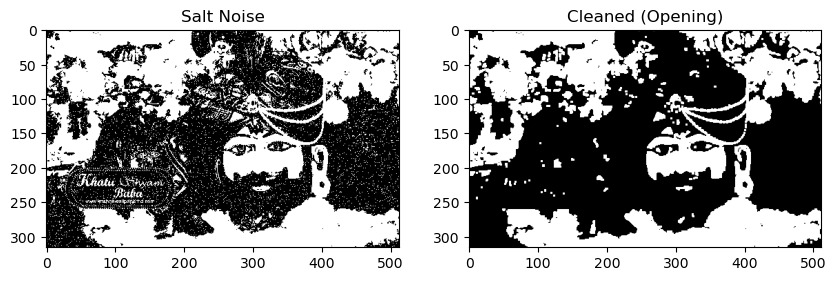

In [12]:
noisy = binary.copy()
noise_mask = np.random.randint(0, 100, noisy.shape)
noisy[noise_mask < 5] = 255 # Add white dots

se = np.ones((3,3), np.uint8)
cleaned = cv2.morphologyEx(noisy, cv2.MORPH_OPEN, se)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(noisy, 'gray'), plt.title('Salt Noise')
plt.subplot(122), plt.imshow(cleaned, 'gray'), plt.title('Cleaned (Opening)')
plt.show()
# Erosion removes small white spots,Dilation restores the main shapes- Hence opening works better

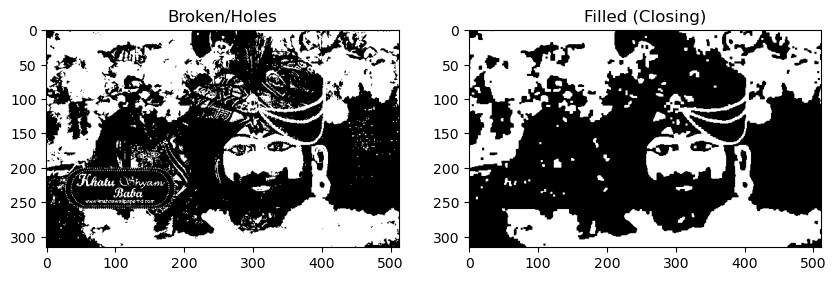

In [13]:
se_small = np.ones((3,3), np.uint8)
denoised = cv2.morphologyEx(binary, cv2.MORPH_OPEN, se_small)
se_fill = np.ones((3,3), np.uint8)
filled = cv2.morphologyEx(denoised, cv2.MORPH_CLOSE, se_fill)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(binary, 'gray'), plt.title('Broken/Holes')
plt.subplot(122), plt.imshow(filled, 'gray'), plt.title('Filled (Closing)')
plt.show()
# If the SE size is too large, nearby objects may merge together and external boundaries of the object will become overly rounded

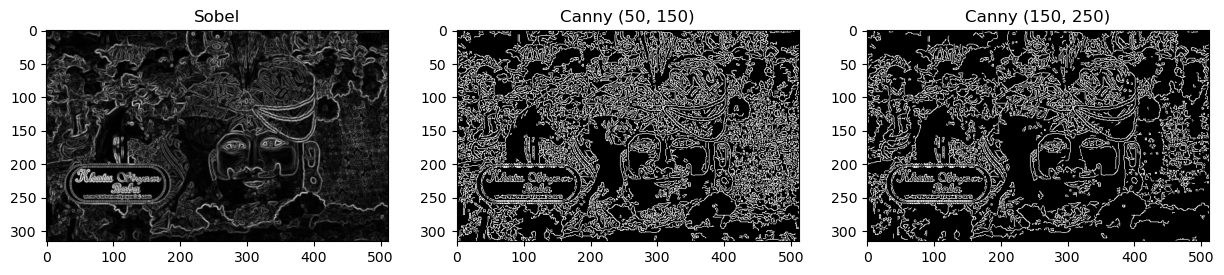

In [14]:
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.magnitude(sobelx, sobely)

canny_low = cv2.Canny(img, 50, 150)
canny_high = cv2.Canny(img, 150, 250)

plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(sobel_combined, 'gray'), plt.title('Sobel')
plt.subplot(132), plt.imshow(canny_low, 'gray'), plt.title('Canny (50, 150)')
plt.subplot(133), plt.imshow(canny_high, 'gray'), plt.title('Canny (150, 250)')
plt.show()
#As thresholds increase in Canny, weak edges (low-gradient textures) disappear

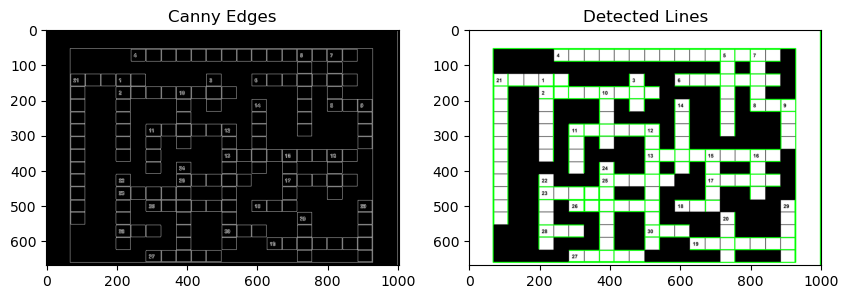

In [22]:
img = cv2.imread('img2.png',0)
edges = cv2.Canny(img, 50, 150)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

line_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) # For colored lines
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(edges, 'gray'), plt.title('Canny Edges')
plt.subplot(122), plt.imshow(line_img), plt.title('Detected Lines')
plt.show()
# When the threshold is too low, it detects too many false lines caused by noise

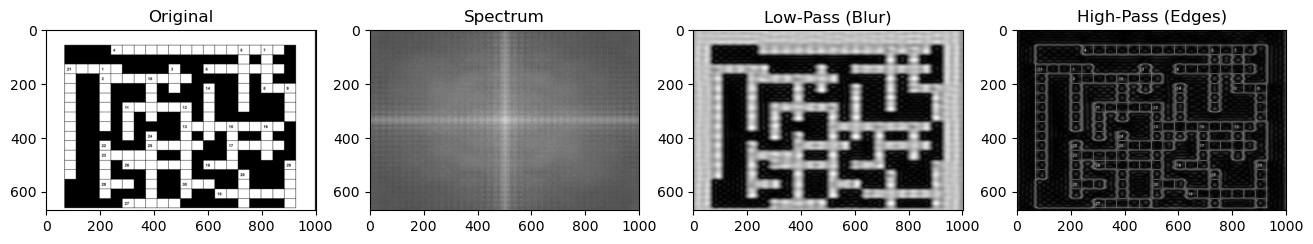

In [23]:
dft = np.fft.fft2(img)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(np.abs(dft_shift))

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2  # center

lp_mask = np.zeros((rows, cols), np.uint8)
cv2.circle(lp_mask, (ccol, crow), 30, 1, -1)

hp_mask = np.ones((rows, cols), np.uint8)
cv2.circle(hp_mask, (ccol, crow), 30, 0, -1)
f_shift_lp = dft_shift * lp_mask
f_shift_hp = dft_shift * hp_mask

img_lp = np.abs(np.fft.ifft2(np.fft.ifftshift(f_shift_lp)))
img_hp = np.abs(np.fft.ifft2(np.fft.ifftshift(f_shift_hp)))

plt.figure(figsize=(16, 4))
plt.subplot(141), plt.imshow(img, 'gray'), plt.title('Original')
plt.subplot(142), plt.imshow(magnitude_spectrum, 'gray'), plt.title('Spectrum')
plt.subplot(143), plt.imshow(img_lp, 'gray'), plt.title('Low-Pass (Blur)')
plt.subplot(144), plt.imshow(img_hp, 'gray'), plt.title('High-Pass (Edges)')
plt.show()

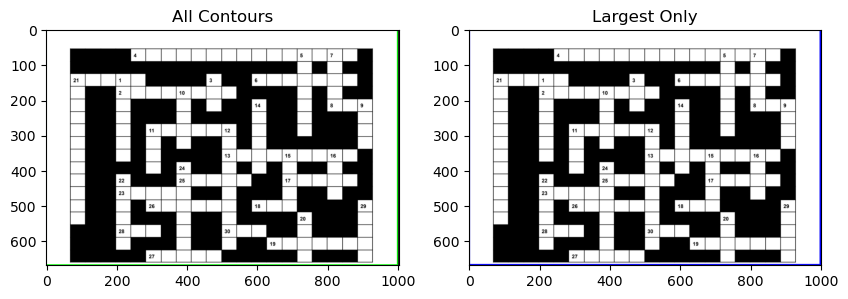

In [24]:
# Thresholding
_, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Detect Contours (Use RETR_EXTERNAL for outer boundaries)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw All Contours
img_all_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_all_contours, contours, -1, (0, 255, 0), 2)

# Find and Draw Largest Contour
img_largest = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
if contours:
    largest = max(contours, key=cv2.contourArea)
    cv2.drawContours(img_largest, [largest], -1, (0, 0, 255), 3)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img_all_contours), plt.title('All Contours')
plt.subplot(122), plt.imshow(img_largest), plt.title('Largest Only')
plt.show()
# If thresholding is poor, the contours will either break into tiny fragments or merge distinct objects into a single blob.

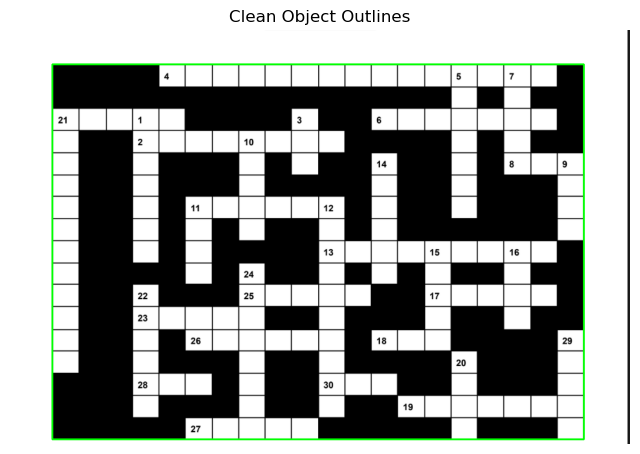

In [25]:
kernel = np.ones((5,5), np.uint8)
cleaned = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

edges = cv2.Canny(cleaned, 100, 200)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

final_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for cnt in contours:
    if cv2.contourArea(cnt) > 500: # Ignore small noise
        cv2.drawContours(final_img, [cnt], -1, (0, 255, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(final_img)
plt.title('Clean Object Outlines')
plt.axis('off')
plt.show()